<a href="https://colab.research.google.com/github/JMindpalace/codestate_section2_project/blob/main/basic_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 문제정의
헬스케어 타겟 선정 전에 한국 사회의 (육체적) 건강도를 알아보려고 합니다.<br>
만약 한국사회가 건강적인 문제가 없다면, 프로젝트 3 이후에서 헬스케어 주제로 사용하지 않을 것입니다.


1.   < 문제 기준 > 현재 40세 이후의 한국 사회는 건강한가요?(육체적 건강을 의미함)
2.   프로젝트 3 이후에 한국시장에서도 헬스케어를 분석할 이유가 있나요?
3.   있다면 어떤 질병을 주목할 것인지, 없다면 이유는 무엇인가요?

---

In [ ]:
!sudo apt install font-manager
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip3 install pdpbox

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from xgboost import XGBClassifier
from imblearn.combine import SMOTEENN, SMOTETomek
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import graphviz

# 데이터셋(한국-공공데이터포털에서 확보함)
국민건강보험공단에서 제공한 '20년도 한국인의 건강 검진 정보'를 분석 대상으로 합니다.<br>
(https://www.data.go.kr/data/15007122/fileData.do)<br><br>

# 데이터 설명(국민건강보험공단에서 제공하는 사용자 메뉴얼을 추가적으로 설명함)
(https://www.data.go.kr/data/15007122/fileData.do#layer_data_infomation)
> 데이터 사이즈 : (1,000,000, 31) - (국민건강보험가입자 중 100만 명 무작위 선별)<br>
> 데이터 기간 : 20년도 건강 검진 자료(매년 12월에 2년 전 자료 추가 방식으로 22년 기준 20년도가 최신 자료)

Feature(총 31개의 열이 있지만 분석에 필요한 16열만 작성함)<BR>
< 검진자 기본 정보 >
  - 성별코드: 1은 남자 / 2는 여자(검진마다 정상 범위가 다름)
  - 연령대 코드(5세단위): '40~44세를 그룹9'로 이후 5세마다 +1로 하여 10개 그룹

< 검진 결과 & 기저 원인 ><br>
{ 생활습관 - 운동 }
  - 신장(5Cm 단위): 키는 내림으로 100~104의 5cm 구간을 100으로 통일
  - 체중(5Kg 단위): 체중 또한 내림으로 70~74의 5kg 구간을 70으로 통일
  - 허리둘레(cm 단위): 남성 90, 여성 85 이상이면 복부비만<br>
  
{ 생활습관 - 문진 }
  - 흡연상태: 1(흡연 경험 없음) / 2(과거에 흡연) / 3(현재도 흡연)
  - 음주여부: 0(음주 안 함) / 1(음주 함)

{ 장기 질환 판단 > 신장 > 혈압 조절 호르몬 분비 }
  - 요단백: 소변에 단백질이 섞인 여부
  - 혈청크레아티닌: 몸 속 노폐물 수치(1.7이상 위험군)<br>

{ 장기 질환 판단 > 간 > 콜레스테롤 조절 }
  - (혈청지오티)AST: 세포 손상 농도(40 이상 위험)
  - (혈청지오티)ALT: 비만 정도에 민감한 반응(40 이상 위험)
  - 감마 지티피: 음주에 민감한 반응(남성 63, 여성 35 이상 위험)

< Target Data ><br>
{ 고혈압 Target }
- 수축기 혈압(mmHG): 검진자의 최고 혈압
- 이완기 혈압(mmHG): 검진자의 최저 혈압<br>

{ 당뇨 Target }
- 식전혈당(공복혈당): 혈액 100ML당 포도당 수치(126이상 당뇨병)<br>

{ 고지혈증 Target }
  - 총 콜레스테롤: 중성지방 + HDL 콜레스테롤 + LDL 콜레스테롤의 총 합


---

In [132]:
df = pd.read_csv('국민건강보험공단_건강검진정보_20211229.CSV', encoding='cp949')
df.shape # 1,000,000 * 31

(1000000, 31)

In [133]:
df.columns

Index(['기준년도', '가입자 일련번호', '시도코드', '성별코드', '연령대 코드(5세단위)', '신장(5Cm단위)',
       '체중(5Kg 단위)', '허리둘레', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '수축기 혈압',
       '이완기 혈압', '식전혈당(공복혈당)', '총 콜레스테롤', '트리글리세라이드', 'HDL 콜레스테롤', 'LDL 콜레스테롤',
       '혈색소', '요단백', '혈청크레아티닌', '(혈청지오티)AST', '(혈청지오티)ALT', '감마 지티피', '흡연상태',
       '음주여부', '구강검진 수검여부', '치아우식증유무', '치석', '데이터 공개일자'],
      dtype='object')

# 1. Feature drop 근거
> 기준년도: 2020년 기준이기에 drop<br>
> 가입자 일련번호: index역활이기에 drop<br>
> 시도코드: 대한민국 전체가 대상이기에 시도 구분이 무의미함<br>
> 시력(좌,우): 시력 감소의 시기는 찾을 수 있지만 해석이 어려움<br>
> 청력(좌,우): 결과에 대한 활용 도메인 부족<br>
> (트리글리세라이드+HDL+LDL): 3가지 콜레스테롤의 합이 총 콜레스테롤이기에 drop<br>
> 혈색소: 빈혈과 연관있지만 혈압과는 무관하기에 drop<br>
> 구강검진 수검여부, 치아우식증유무, 치석 : 치아는 양치를 통해 관리 가능<br>
> 데이터 공개일자: 공개일자가 같이게 drop

In [134]:
drop_col = ['기준년도', '가입자 일련번호','시도코드','시력(좌)','시력(우)','청력(좌)','청력(우)','트리글리세라이드', 'HDL 콜레스테롤', 'LDL 콜레스테롤',
            '혈색소','구강검진 수검여부','치아우식증유무','치석','데이터 공개일자']
df = df.drop( drop_col, axis=1 )
df.shape # 1,000,000 * 16

(1000000, 16)

# 2. Row drop 근거
0. Dataset size
   > 백 만개의 데이터셋 크기로 진행이 어려움<br>
   > 따라서 수치의 조정보다는 drop을 목표로 함

0. 의료적 수치의 임의적 변경 불가
   > 해당 데이터셋의 경우 개개인의 검진을 통해 획득한 데이터<br>
   > 따라서 평균 등의 임의적 변경은 오염된 데이터셋이 되기에 drop을 목표로 함

1. null data
   > 최대 null인 '총 콜레스테롤'의 경우 597,694로 많지만<br>
   > (중성지방, HDL, LDL에서도 공란, 즉 합산을 통한 변경 불가능)<br>
   > 제거 이후에도 약 40만의 데이터가 남아서 drop을 결정함

In [135]:
print( df.isnull().sum() )
df = df.dropna()
df.shape # 399,987, 16

성별코드                 0
연령대 코드(5세단위)         0
신장(5Cm단위)            0
체중(5Kg 단위)           0
허리둘레               108
수축기 혈압            7532
이완기 혈압            7534
식전혈당(공복혈당)        7602
총 콜레스테롤         597694
요단백              12141
혈청크레아티닌           7602
(혈청지오티)AST        7601
(혈청지오티)ALT        7602
감마 지티피            7603
흡연상태               343
음주여부               196
dtype: int64


(399987, 16)

In [136]:
# 열이름이 너무 복잡해서 우선 정리
df.columns = [ '성별', '연령대', '신장', '체중', '허리둘레', '최고혈압', '최저혈압', '공복혈당', '총콜레스테롤', '요단백', '혈청크레아티닌', 'AST', 'ALT', '감마GTP', '흡연', '음주' ]
df.columns

Index(['성별', '연령대', '신장', '체중', '허리둘레', '최고혈압', '최저혈압', '공복혈당', '총콜레스테롤',
       '요단백', '혈청크레아티닌', 'AST', 'ALT', '감마GTP', '흡연', '음주'],
      dtype='object')

# Target Engineering
> 병을 지정하고, 기저를 찾는 방식으로 분류가 적정하다고 판단됨<br>
> 병의 기저를 파악하면, 기저의 회귀적 예측도 가능하다고 판단됨

In [137]:
# 혈압 수치를 고혈압 Target으로 변경
df['고혈압'] = np.zeros( len(df) ).astype(int)
df.loc[ (df['최고혈압'] > 140 ) & (df['최저혈압'] > 90) , '고혈압' ] = 1
bp_drop = ['최고혈압', '최저혈압']
df = df.drop( bp_drop, axis=1 )
df.shape  # 399,987, 15

(399987, 15)

In [138]:
# 공복혈당 수치를 당뇨 Target으로 변경
df['당뇨'] = np.zeros( len(df) ).astype(int)
df.loc[ (df['공복혈당'] >= 126 ) , '당뇨' ] = 1
df = df.drop( '공복혈당', axis=1 )
df.shape  # 399,987, 15

(399987, 15)

In [139]:
# 총콜레스테롤 수치를 고지혈증 Target으로 변경
df['고지혈증'] = np.zeros( len(df) ).astype(int)
df.loc[ (df['총콜레스테롤'] >= 250 ) , '고지혈증' ] = 1
df = df.drop( '총콜레스테롤', axis=1 )
df.shape  # 399,987, 15

(399987, 15)

# Feature Engineering

In [140]:
# 연령대 그룹을 대표하는 나이로 변경 & 85세 이상은 1,700명으로 80세로 모두 편입
df['연령대'] = df['연령대'].replace( { 9:40, 10:45, 11:50, 12:55, 13:60, 14:65, 15:70, 16:75, 17:80, 18:80 } )
df['연령대'].value_counts()

60    88721
40    84677
50    47883
45    46447
55    45541
65    32252
70    23432
80    15621
75    15413
Name: 연령대, dtype: int64

In [141]:
# 체중, 신장 데이터보다는 BMI로 통합 관리
df['BMI'] = round( df['체중'] / (df['신장']*df['신장']) * 10000 , 2)
bmi_drop = ['체중', '신장']
df = df.drop( bmi_drop, axis=1 )
df.shape # 399,987, 14

(399987, 14)

In [142]:
# 요단백의 수치를 1회 배출되는 단백질의 양으로 변환
df['단백뇨'] = np.zeros( len(df) ).astype(int)

df.loc[ (df['요단백'] <= 2.0 ) , '단백뇨' ] = 0
df.loc[ (df['요단백'] == 3.0 ) , '단백뇨' ] = 30
df.loc[ (df['요단백'] == 4.0 ) , '단백뇨' ] = 100
df.loc[ (df['요단백'] == 5.0 ) , '단백뇨' ] = 300
df.loc[ (df['요단백'] == 6.0 ) , '단백뇨' ] = 1000

df = df.drop( '요단백', axis=1 )
df.shape  # 399,987, 14

(399987, 14)

In [143]:
# 소수점이 필요없는 열은 int로 변경
df['AST'] = df['AST'].astype(int)
df['ALT'] = df['ALT'].astype(int)
df['감마GTP'] = df['감마GTP'].astype(int)

df['흡연'] = df['흡연'].astype(int) # 추후 Object로 두고 ordinal 검토
df['음주'] = df['음주'].astype(int)

In [144]:
# 연관성 있는 칼럼끼리 재배치
df = df[[ '성별', '연령대',                       # 기본 정보
          'BMI', '허리둘레', '흡연', '음주',      # 기저원인: 생활습관 - 운동&문진
          '단백뇨', '혈청크레아티닌',             # 기저원인: 장기 신장 질환
          'AST', 'ALT', '감마GTP',                # 기저원인: 장기 간 질환
          '고혈압', '당뇨', '고지혈증' ]]         # Target Data
df.head(5)

,성별,연령대,BMI,허리둘레,흡연,음주,단백뇨,혈청크레아티닌,AST,ALT,감마GTP,고혈압,당뇨,고지혈증
0,1,40,22.04,72.1,1,0,0,1.1,21,27,21,0,0,0
4,2,55,20.81,75.2,1,0,0,0.7,18,17,14,0,0,0
5,1,40,24.84,94.0,3,1,0,1.1,25,32,26,0,0,0
6,1,40,29.38,93.0,3,1,0,0.7,18,20,35,0,1,0
8,2,80,22.22,82.0,1,0,0,0.7,42,48,39,0,0,0


In [145]:
df.to_csv('40만_검진정보.csv', index=False) # 기본 전처리 끝

---

# **가설**
1. 타겟 질병(고혈압, 당뇨, 고지혈증)은 ALT와 관련이 크다.
   > ALT의 경우 비만에 민감한데, 질병 모두 체중과 연관이 클 것이다.<BR>
   > 다른 AST는 약이나 질병 감염, GTP는 음주로 2, 3순위로 예상됨
2. 신장 질환 판단 기준 2가지는 고혈압에 관련이 크다.
   > 요단백, 혈청크레아티닌 모두 신장 기능의 수치인데<BR>
   > 값이 클수록 신장의 문제로 혈압 조절이 불가능해져서 관련이 큼
3. 한국은 건강한 사회인가? 헬스케어가 필요한 매력적인 시장인가?
   
---

# 타겟 비율 확인
> 5%, 10%, 10% 씩으로 분포의 불균형이 심함<br>
> 하지만 불균형을 통해 건강한 사람의 비율이 많다는 판단 근거 1로 충족함<br>

> 또한 질병의 비율 자체로 가능한 추정
1. 고혈압 환자는 젊은 나이의 사망으로 생존 인원 자체가 적음<br>
   (즉, 고혈압은 갑작스러운 상황에 대비하기가 어려움)
2. 당뇨, 고지혈증의 질환은 평소의 관리로 호전적으로 수명 연장이 가능하다.

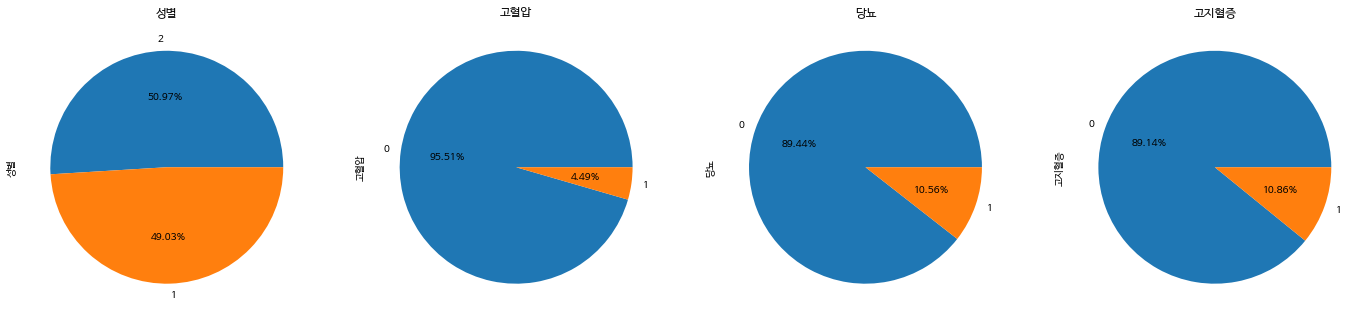

In [146]:
plt.rc('font', family='NanumBarunGothic')

fig , i, plot_target = plt.figure(figsize=(24,8)), 1, ['성별','고혈압','당뇨','고지혈증']
for f in plot_target:
  plt.subplot(1,4,i)
  df[f].value_counts(normalize=True).plot.pie(autopct="%.2f%%")
  plt.title(f)
  i += 1

# Feature 이상치 확인&제거
> 이상치 중 일부를 고위험군으로 분류하고 당장 치료가 필요한 경우로 판단하여 배제함(정상치 2배이상 등)

> 고령화로 인해 65세 이상은 검사 비율이 평균 4만에 비해 현저히 적음<br>
> 65세 이상에서 이상 징후를 발견할 수도 있음

In [147]:
df['연령대'].value_counts()

60    88721
40    84677
50    47883
45    46447
55    45541
65    32252
70    23432
80    15621
75    15413
Name: 연령대, dtype: int64

BMI의 경우 나이에 따라 약간의 차이가 있지만 40대 이상은 25 이상을 과체중으로 설정
> BMI를 보면 여성보다 남성이 더 위험비율이 많다
> 하지만 허리둘레 즉, 복부비만은 여성이 더 많다.<br>
  (여성의 경우 폐경기 이후에는 다른 부위보다 복부에 지방이 잘 쌓인다고 함)

> 여성의 호르몬까지 고려하여 허리둘레를 고려한다면<br>
> 비만인 인구는 남성이 더 많다고 할 수 있다.

330


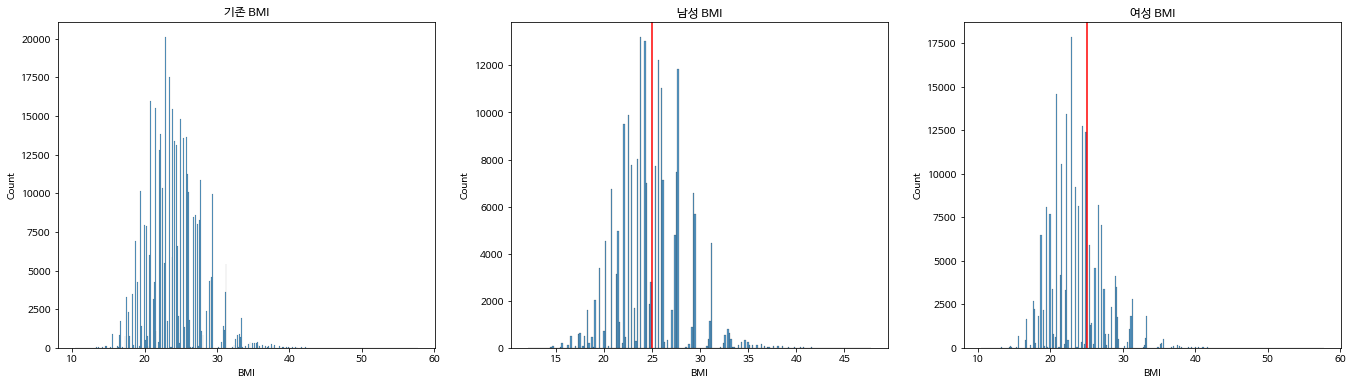

In [148]:
fig, emp_df, emp_df_male, emp_df_female = plt.figure(figsize=(23,6)), df.copy(), df[ df['성별'] ==1].copy(), df[ df['성별'] ==2].copy()
plt.subplot(1,3,1)
sns.histplot(emp_df['BMI'])
plt.title('기존 BMI')

print( len( df[df['BMI'] > 40] ) ) # BMI 30 이상이 위험군이기에 40 초과는 수도 적고 너무 위험군으로 제거함
df = df[df['BMI'] < 40]

plt.subplot(1,3,2)
sns.histplot(emp_df_male['BMI'])
plt.axvline(25, color='red')
plt.title('남성 BMI')

plt.subplot(1,3,3)
sns.histplot(emp_df_female['BMI'])
plt.axvline(25, color='red')
plt.title('여성 BMI');

104


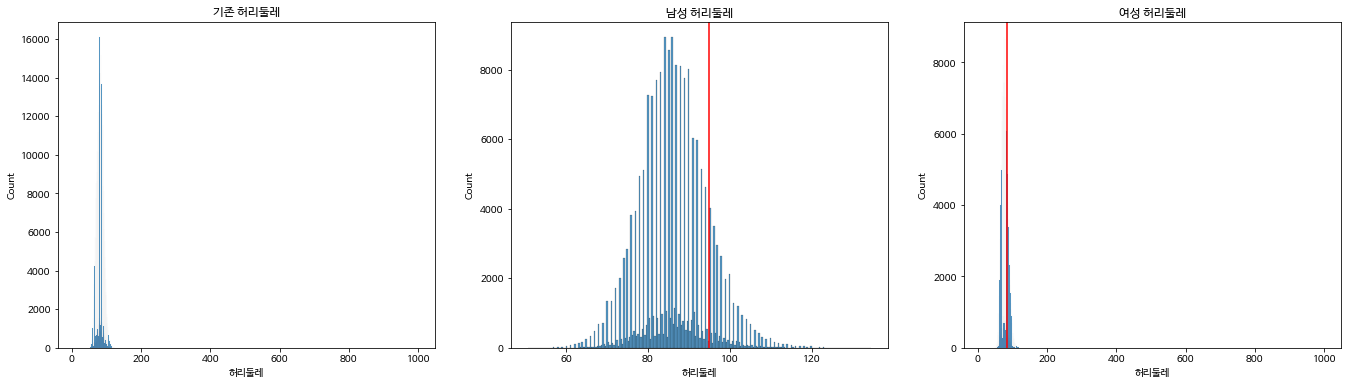

In [149]:
fig, emp_df, emp_df_male, emp_df_female = plt.figure(figsize=(23,6)), df.copy(), df[ df['성별'] ==1].copy(), df[ df['성별'] ==2].copy()

plt.subplot(1,3,1)
sns.histplot(emp_df['허리둘레'])
plt.title('기존 허리둘레')

print( len( (df[df['허리둘레'] > 120]) + (df[df['허리둘레'] < 50]) ) ) # 허리둘레는 남성이 90, 여성이 85가 넘으면 복부비만으로 120 초과는 고위험군이기에 제거, 50이하는 3명뿐이기에 제거
df = df[ (df['허리둘레']<120) & (df['허리둘레'] > 50) ]

plt.subplot(1,3,2)
sns.histplot(emp_df_male['허리둘레'])
plt.axvline(95, color='red')
plt.title('남성 허리둘레')

plt.subplot(1,3,3)
sns.histplot(emp_df_female['허리둘레'])
plt.axvline(85, color='red')
plt.title('여성 허리둘레');

생활습관 중 흡연과 음주 비율
> 흡연자가 적기에 질병 발병이 적을 수 있다<br>
> 추후 흡연자와 비흡연자의 비교도 필요함

> 음주의 비율은 거의 비슷한 상황이기에<br>
> 술은 설정 질병에 영향을 못 줄 수도 있다.

In [150]:
df['흡연'].value_counts() # 비흡연자 25만 vs 흡연 15만으로 적절하다고 판단

1    255832
2     73845
3     69774
Name: 흡연, dtype: int64

In [151]:
df['음주'].value_counts() # 적절한 비율로 판단

1    229298
0    170153
Name: 음주, dtype: int64

In [152]:
df['단백뇨'].value_counts() # 38만 vs 1만 3천으로 불균형 - 해석 시 고려사항

0       385542
30        9290
100       3298
300       1029
1000       292
Name: 단백뇨, dtype: int64

혈청크레아티닌은 몸 속의 노폐물의 수치로 정상치 이상은 신장에 문제가 있다고 판단하지만<br>
> 거의 대부분이 정상치이기에 비교가 어려울 것으로 예상

545


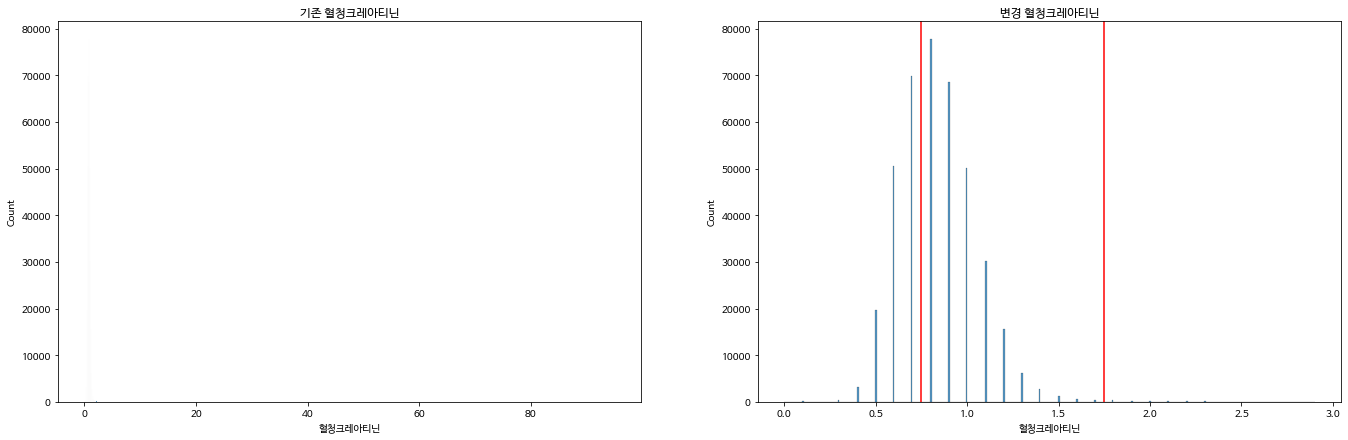

In [153]:
fig, emp_df = plt.figure(figsize=(23,7)), df.copy()
plt.subplot(1,2,1)
sns.histplot(emp_df['혈청크레아티닌'])
plt.title('기존 혈청크레아티닌')

print( len( df[df['혈청크레아티닌'] > 3] ) ) # 0.8~1.7이 정상치, 3이상은 고위험군으로 제거
df = df[df['혈청크레아티닌']<3]

plt.subplot(1,2,2)
sns.histplot(df['혈청크레아티닌'])
plt.axvline(0.75, color='red')
plt.axvline(1.75, color='red')
plt.title('변경 혈청크레아티닌');

ALT는 비만에 민감한 수치이지만 대부분이 정상범주 내에 있음
> 하지만 BMI나 허리둘레 인구와는 비슷한 비율을 보임

4401


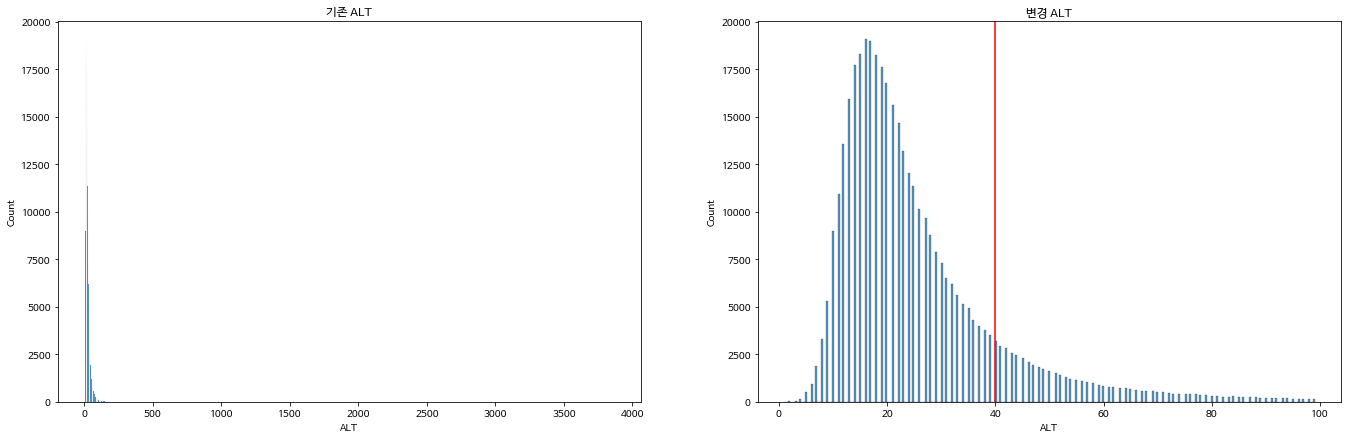

In [154]:
fig, emp_df = plt.figure(figsize=(23,7)), df.copy()
plt.subplot(1,2,1)
sns.histplot(emp_df['ALT'])
plt.title('기존 ALT')

print( len( df[df['ALT'] > 100] ) ) # 정상치가 0~40으로 정상치의 2배 이상은 고위험군으로 제거
df = df[df['ALT'] < 100]

plt.subplot(1,2,2)
sns.histplot(df['ALT'])
plt.axvline(40, color='red')
plt.title('변경 ALT');

1053


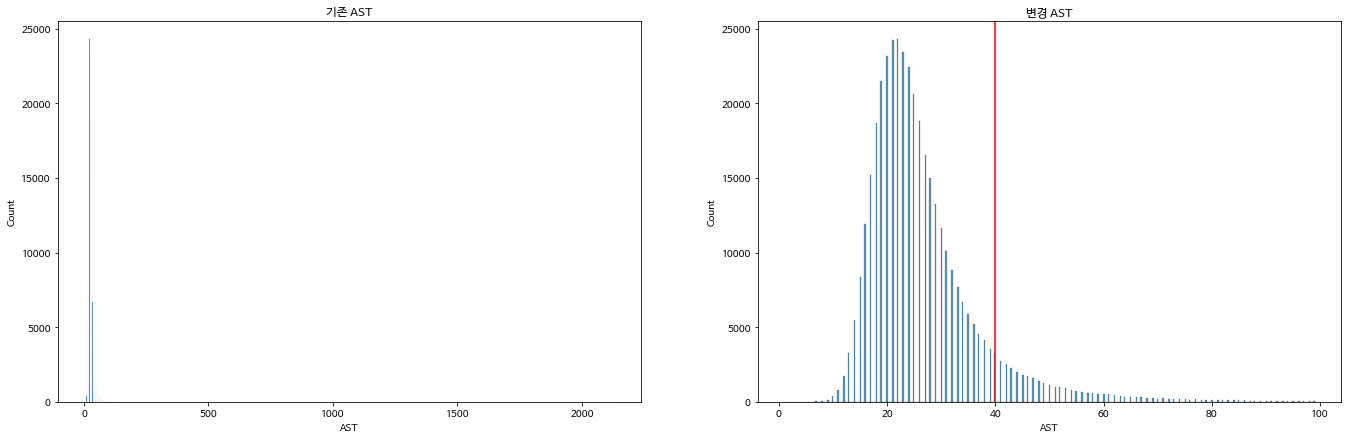

In [155]:
fig, emp_df = plt.figure(figsize=(23,7)), df.copy()
plt.subplot(1,2,1)
sns.histplot(emp_df['AST'])
plt.title('기존 AST')

print( len( df[df['AST'] > 100] ) ) # 정상치가 0~40으로 정상치의 2배 이상은 고위험군으로 제거
df = df[df['AST'] < 100]

plt.subplot(1,2,2)
sns.histplot(df['AST'])
plt.axvline(40, color='red')
plt.title('변경 AST');

감마지피티의 경우 음주에 민감한 검진인데 많은 수가 남성의 최대 정상치인 63내에 있음<br>
> 음주의 문답의 오류가 있을 수 있음<br>
  (자존심으로 과장 대답, 달 1회 등 기한의 오류 등)

8015


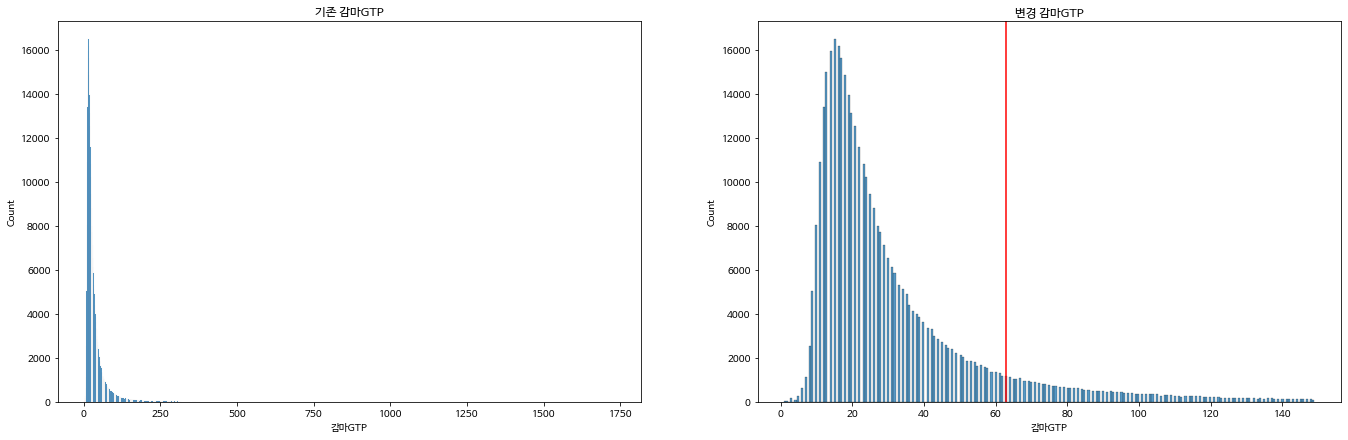

In [156]:
fig, emp_df = plt.figure(figsize=(23,7)), df.copy()
plt.subplot(1,2,1)
sns.histplot(emp_df['감마GTP'])
plt.title('기존 감마GTP')

print( len( df[df['감마GTP'] > 150] ) ) # 정상치 높은 남성이 11~63으로 정상치의 2배 이상은 고위험군으로 제거
df = df[df['감마GTP'] < 150]

plt.subplot(1,2,2)
sns.histplot(df['감마GTP'])
plt.axvline(63, color='red')
plt.title('변경 감마GTP');

In [157]:
df.reset_index(inplace=True)
df = df.drop( 'index', axis=1 )

print( df.shape )
df.head(3)

(385123, 14)


,성별,연령대,BMI,허리둘레,흡연,음주,단백뇨,혈청크레아티닌,AST,ALT,감마GTP,고혈압,당뇨,고지혈증
0,1,40,22.04,72.1,1,0,0,1.1,21,27,21,0,0,0
1,2,55,20.81,75.2,1,0,0,0.7,18,17,14,0,0,0
2,1,40,24.84,94.0,3,1,0,1.1,25,32,26,0,0,0


In [158]:
df.to_csv('38만_검진정보.csv', index=False) # 전처리 종료



---



# 데이터 분리

In [159]:
train , val = train_test_split( df[ df['성별'] == 1].copy(), test_size=0.2 )
target = '당뇨' # ['고혈압 - 5%','당뇨 - 10%','고지혈증 - 10%']

def X_y_split(df):
  X = df.drop(target, axis=1)
  y = df[target]
  return X, y

X_train, y_train = X_y_split(train)
X_val, y_val = X_y_split(val)

# 기본 모델링 - 트리

In [160]:
base = y_train.mode()[0]
baseline = len(y_train) * [base]
baseline_acc = accuracy_score(y_train, baseline)
print(f'기준모델의 정확도는 {baseline_acc.round(3)} 입니다')

기준모델의 정확도는 0.872 입니다


In [161]:
tree_model = DecisionTreeClassifier(random_state=42, criterion="entropy", max_depth=10)
tree_model.fit(X_train, y_train)

print("훈련 정확도", tree_model.score(X_train, y_train).round(2))
print("검증 정확도", tree_model.score(X_val, y_val).round(2))

y_pred = tree_model.predict(X_val)
print(classification_report(y_val, y_pred))

훈련 정확도 0.88
검증 정확도 0.87
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     32127
           1       0.37      0.03      0.05      4830

    accuracy                           0.87     36957
   macro avg       0.62      0.51      0.49     36957
weighted avg       0.81      0.87      0.81     36957



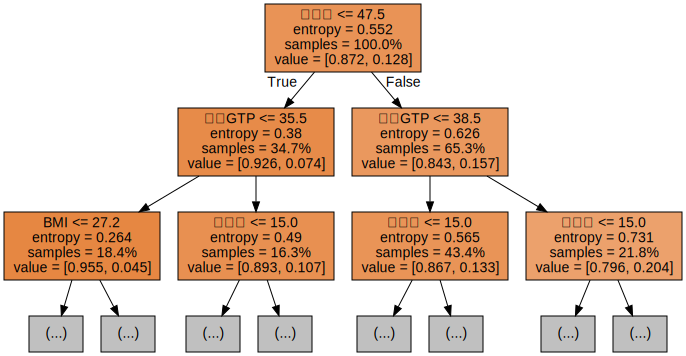

'tree.png'

In [162]:
dot_data = export_graphviz(tree_model,
                           max_depth=2,
                           feature_names=X_val.columns,
                           filled=True,
                           proportion=True)
display(graphviz.Source(dot_data))

graphviz.Source(dot_data).render('tree', format="png")

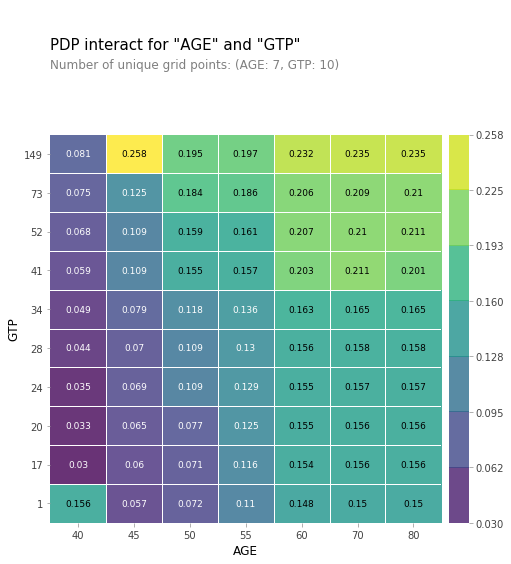

In [163]:
target_features = ["연령대", "감마GTP"]

interaction = pdp_interact(
    model=tree_model,
    dataset=X_val,
    model_features=X_val.columns,
    features=target_features,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=['AGE', 'GTP']);

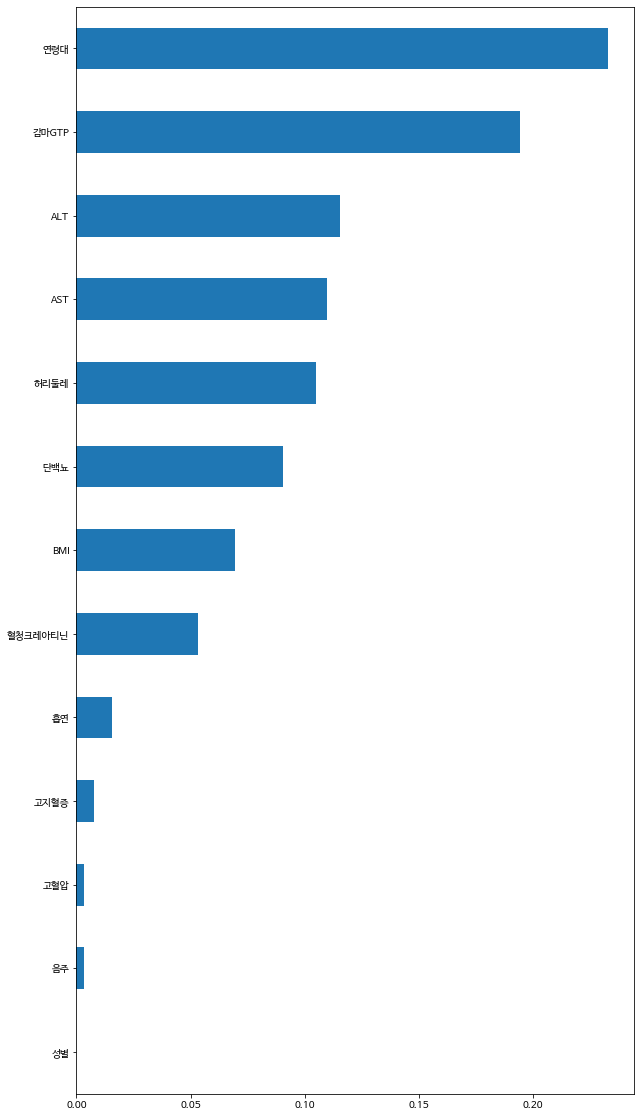

In [164]:
%matplotlib inline
import matplotlib.pyplot as plt

importances = pd.Series(tree_model.feature_importances_, X_train.columns)
plt.figure(figsize=(10, 20))
importances.sort_values().plot.barh();

In [165]:
X_val_ice = X_val.copy()
X_val_ice.reset_index(inplace=True)
X_val_ice = X_val_ice.drop( 'index', axis=1 )

In [166]:
X_val_ice[ (X_val_ice['연령대']== 40) & (X_val_ice['성별']== 2) ].head(10)

,성별,연령대,BMI,허리둘레,흡연,음주,단백뇨,혈청크레아티닌,AST,ALT,감마GTP,고혈압,고지혈증


In [167]:
X_val_ice.iloc[[72,262,317]]

,성별,연령대,BMI,허리둘레,흡연,음주,단백뇨,혈청크레아티닌,AST,ALT,감마GTP,고혈압,고지혈증
72,1,60,23.88,82.0,2,1,0,0.9,21,27,80,0,1
262,1,75,21.48,83.0,1,0,0,1.2,15,14,22,0,0
317,1,45,22.04,71.0,3,1,0,1.1,16,10,17,0,0


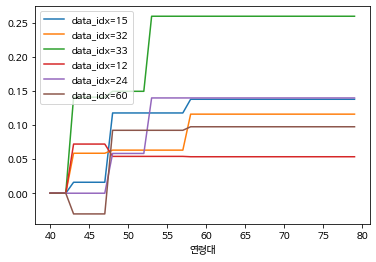

In [168]:
def get_ice_plot_data(data, data_index, target_feature, target_feature_range):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred_proba = tree_model.predict_proba(one_datapoint)[:, 1]
        results.append(one_datapoint_pred_proba.item())
    results = np.array(results)
    return target_feature_range, results - results[0]

target_feature = "연령대"
target_feature_range = range(X_val_ice["연령대"].min(), X_val_ice["연령대"].max())
for data_index in [15,32,33,  12,24,60]:
    plt.plot(
        *get_ice_plot_data(
            X_val_ice, data_index, target_feature, target_feature_range
        ),
        label=f"data_idx={data_index}",
    )
plt.xlabel(target_feature);
plt.legend();

# 추가적 모델링

In [169]:
tree_model = RandomForestClassifier(random_state=42, oob_score=True, n_jobs=-1)
tree_model.fit(X_train, y_train)

print("훈련 정확도", tree_model.score(X_train, y_train).round(2))
print("검증 정확도", tree_model.score(X_val, y_val).round(2))

y_pred = tree_model.predict(X_val)
print(classification_report(y_val, y_pred))

훈련 정확도 1.0
검증 정확도 0.87
              precision    recall  f1-score   support

           0       0.87      1.00      0.93     32127
           1       0.38      0.01      0.02      4830

    accuracy                           0.87     36957
   macro avg       0.62      0.50      0.48     36957
weighted avg       0.81      0.87      0.81     36957



In [170]:
X_train_sampled, y_train_sampled = SMOTETomek(random_state=42).fit_resample( X_train, y_train )

model = XGBClassifier(
    
    objective = "binary:logistic", # 2진 로지스틱회귀 분류

    eval_metric = "auc", # 평가지표는 분류이기에 AUC

    n_estimators = 9999999, # 모델 갯수는 높게하고, early_stopping 사용

    random_state = 42, # 차후 검증을 위해 고정

    n_jobs=-1, # 모든 자원 사용

    max_depth = 8, # 트리의 최대 깊이

    learning_rate = 0.1, # 학습률은 0.01~ 0.2 사이

    scale_pos_weight = (y_train_sampled == 0).sum() / (y_train_sampled == 1).sum()
)

watchlist = [(X_train_sampled, y_train_sampled), (X_val, y_val)]

model.fit(
    X_train_sampled, y_train_sampled,
    eval_set = watchlist,
    early_stopping_rounds = 30,  # 30 동안 성능 개선
)

[0]	validation_0-auc:0.794683	validation_1-auc:0.619935
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.836686	validation_1-auc:0.629122
[2]	validation_0-auc:0.846649	validation_1-auc:0.631331
[3]	validation_0-auc:0.876029	validation_1-auc:0.63957
[4]	validation_0-auc:0.881805	validation_1-auc:0.640503
[5]	validation_0-auc:0.889959	validation_1-auc:0.643612
[6]	validation_0-auc:0.896776	validation_1-auc:0.647274
[7]	validation_0-auc:0.904643	validation_1-auc:0.650377
[8]	validation_0-auc:0.906919	validation_1-auc:0.651784
[9]	validation_0-auc:0.914792	validation_1-auc:0.655899
[10]	validation_0-auc:0.917916	validation_1-auc:0.65651
[11]	validation_0-auc:0.920565	validation_1-auc:0.658947
[12]	validation_0-auc:0.922507	validation_1-auc:0.662029
[13]	validation_0-auc:0.925543	validation_1-auc:0.663594
[14]	validation_0-auc:0.926431	validation_1-auc:0.665007


XGBClassifier(eval_metric='auc', max_depth=8, n_estimators=9999999, n_jobs=-1,
              random_state=42, scale_pos_weight=1.0)

# 모델 평가

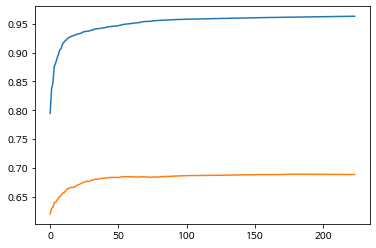

검증 정확도 0.8652758611359147
              precision    recall  f1-score   support

           0       0.87      0.99      0.93     32127
           1       0.38      0.05      0.09      4830

    accuracy                           0.87     36957
   macro avg       0.63      0.52      0.51     36957
weighted avg       0.81      0.87      0.82     36957

ROC-AUC: 0.6889501429400823


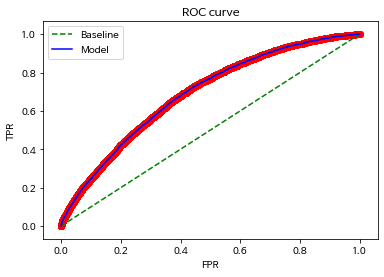

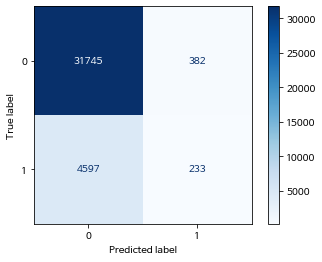

In [171]:
def get_roc_auc(model, X_val, y_val):
    if isinstance(model, XGBClassifier):
        y_pred_proba = model.predict_proba(
            X_val)[:, 1] # , iteration_range=(0, model.best_iteration)
        
    else:
        y_pred_proba = model.predict_proba(X_val)[:, 1]

    print("ROC-AUC:", roc_auc_score(y_val, y_pred_proba))

    baseline_fpr, baseline_tpr, _ = roc_curve(y_val, [0] * len(y_val))
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    tmp = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'thresholds': thresholds})
    plt.plot(
        baseline_fpr, baseline_tpr, linestyle="--", color="green", label="Baseline"
    )
    plt.plot(fpr, tpr, color="blue", label="Model")
    plt.scatter(fpr, tpr, color="red")
    plt.legend()
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    return tmp


def plot_confusion_matrix(model, X_val, y_val):
    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val, iteration_range=(0, model.best_iteration))
    else:
        y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues')
    plt.show()


def summarize_results(model, X_val, y_val):
  if isinstance(model, XGBClassifier):
    results = model.evals_result()
    tgts = results["validation_0"].keys()
    
    for tgt in tgts:
      train_error = results["validation_0"][tgt]
      val_error = results["validation_1"][tgt]
      
      plt.plot(train_error, label="Train")
      plt.plot(val_error, label="Validation")
      plt.show()

    print("검증 정확도", model.score(X_val, y_val))

    if isinstance(model, XGBClassifier):
        y_pred = model.predict(X_val) # , iteration_range=(0, model.best_iteration+1)
    else:
        y_pred = model.predict(X_val)

    print(classification_report(y_val, y_pred))

    get_roc_auc(model, X_val, y_val)

    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val,cmap='Blues')
    plt.show()

summarize_results(model, X_val, y_val)

# MDI

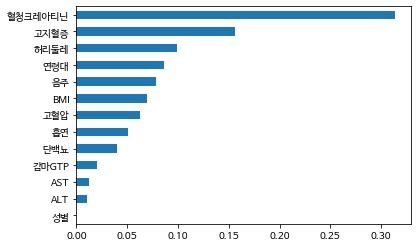

In [172]:
importances = pd.Series(model.feature_importances_, X_train.columns)

importances.sort_values().plot.barh()

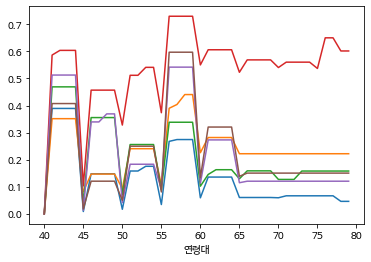

In [173]:
def get_ice_plot_data(data, data_index, target_feature, target_feature_range):
    one_datapoint = data.iloc[[data_index]].copy()
    results = []

    for target_value in target_feature_range:
        one_datapoint[target_feature] = target_value
        one_datapoint_pred_proba = model.predict_proba(one_datapoint)[:, 1]
        results.append(one_datapoint_pred_proba.item())
    results = np.array(results)
    return target_feature_range, results - results[0]

target_feature = "연령대"
target_feature_range = range(X_val["연령대"].min(), X_val["연령대"].max())
for data_index in [22,1,31,  95,77,13]: # 40대여성흡연음주 없음=22, 음주있음=1, 흡연음주모두=31 / 40대남성흡연음주 없음=95, 음주있음=77, 흡연음주모두=13
    plt.plot(
        *get_ice_plot_data(
            X_val, data_index, target_feature, target_feature_range
        ),
        label=f"data_idx={data_index}",
    )
plt.xlabel(target_feature);

# PDP

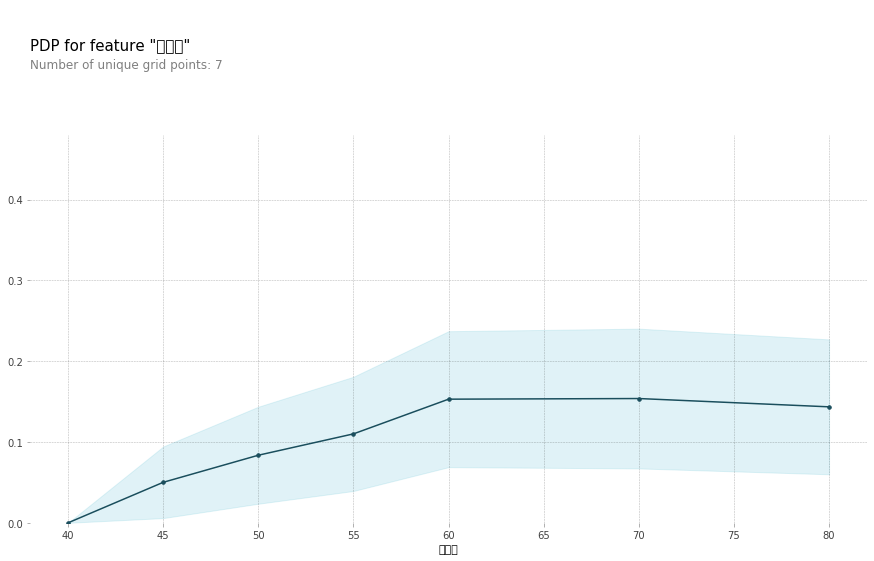

In [174]:
target_feature = "연령대"

isolated = pdp_isolate(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    feature=target_feature,
)
pdp_plot(isolated, feature_name=target_feature);

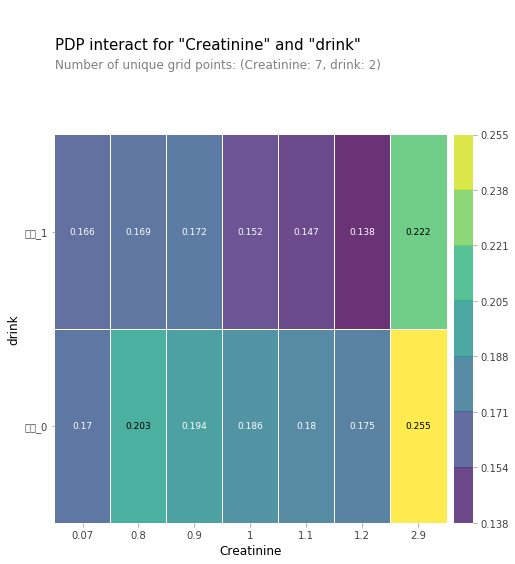

In [175]:
target_features = ["혈청크레아티닌", "음주"]

interaction = pdp_interact(
    model=model,
    dataset=X_val,
    model_features=X_val.columns,
    features=target_features,
)
pdp_interact_plot(interaction, plot_type="grid", feature_names=['Creatinine', 'drink']);